
✅ Tuned Model Performance:
📊 RMSE: ₹0.93 lakhs
📊 MAE: ₹0.61 lakhs
📊 R² Score: 0.96
🚗 Predicted Selling Price: ₹4.57 lakhs


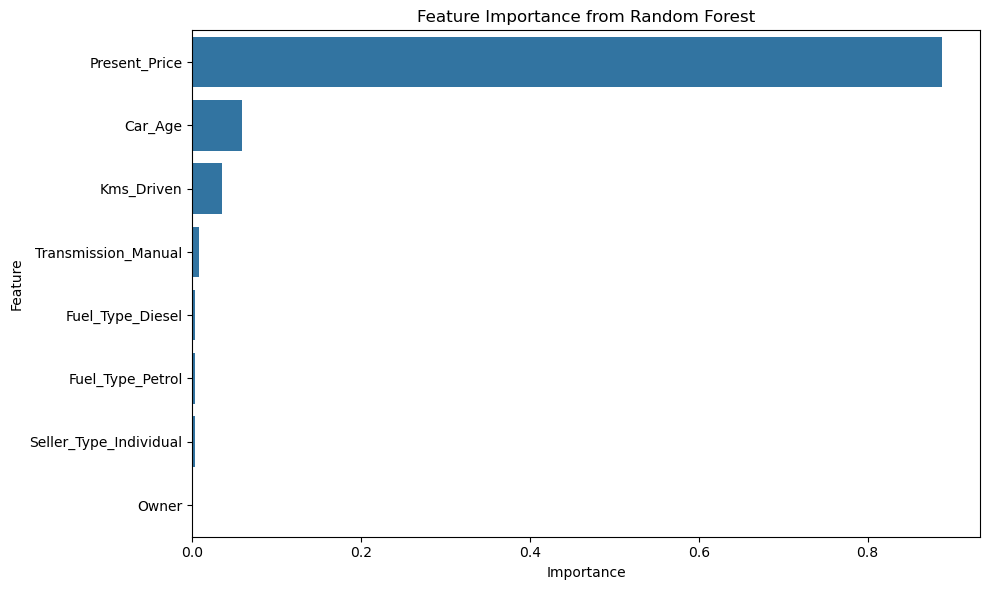

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("car.csv")
df.dropna(inplace=True)
df['Car_Age'] = 2025 - df['Year']
df.drop(['Car_Name', 'Year'], axis=1, inplace=True)


X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

categorical_cols = ['Fuel_Type', 'Seller_Type', 'Transmission']
numerical_cols = ['Present_Price', 'Kms_Driven', 'Owner', 'Car_Age']


preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_cols),
    ('num', StandardScaler(), numerical_cols)
])


base_model = RandomForestRegressor(random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', base_model)
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

search = RandomizedSearchCV(pipeline, param_distributions=param_dist, 
                            n_iter=10, cv=5, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
search.fit(X_train, y_train)


best_pipeline = search.best_estimator_


y_pred = best_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n✅ Tuned Model Performance:")
print(f"📊 RMSE: ₹{rmse:.2f} lakhs")
print(f"📊 MAE: ₹{mae:.2f} lakhs")
print(f"📊 R² Score: {r2:.2f}")


joblib.dump(best_pipeline, "car_price_prediction_pipeline.pkl")


sample_input = pd.DataFrame([{
    'Present_Price': 5.9,
    'Kms_Driven': 35000,
    'Owner': 0,
    'Car_Age': 7,
    'Fuel_Type': 'Petrol',
    'Seller_Type': 'Individual',
    'Transmission': 'Manual'
}])
predicted_price = best_pipeline.predict(sample_input)[0]
print(f"🚗 Predicted Selling Price: ₹{predicted_price:.2f} lakhs")

encoder = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = encoder.get_feature_names_out(categorical_cols)
all_features = list(cat_feature_names) + numerical_cols


importances = best_pipeline.named_steps['regressor'].feature_importances_
feat_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()
